In [30]:
# !wget "https://raw.githubusercontent.com/Henriquelay/AI-classes/main/Trab1/hemofilia.csv" -O "hemofilia.csv" -nc

# Data ingestion
import pandas as pd

# My school enrollment id ends with `4`, so I'm assigned to TaskI, which is to classify the severity of hemophilia
assigned_task = "Calculated_Severity"

df = pd.read_csv("hemofilia.csv")
df.head()

,AA_HGVS,AA_Legacy,aa1,AA_dist,psi,phi,bfactor,areaSAS,areaSES,kdHydrophobicity,ConsurfDB,degree,betweenness,closeness,burts,pr,auth,kcore,Calculated_Severity
0,26,7,Leu,1.622514,150.866429,-107.867773,146.53,4.380023,20.015846,3.8,-793.0,8.0,0.010313,0.115715,0.225146,0.000859,0.074260,4.0,Severe
1,28,9,Ala,1.523528,18.239183,168.251651,139452.00,0.000000,0.000000,1.8,-1019.0,10.0,0.004677,0.107229,0.179909,0.001077,0.081676,4.0,Moderate
2,29,10,Val,1.568551,116.506984,-35.703606,193867.00,10.603600,41.534812,4.2,-746.0,7.0,0.002008,0.101614,0.239194,0.000837,0.043540,4.0,Severe
3,31,12,Leu,1.641493,177.755055,-104.656175,154735.00,45.264135,75.880436,3.8,-134.0,7.0,0.002169,0.097581,0.263617,0.000879,0.034803,4.0,Moderate
4,34,15,Asp,1.602138,-66.129605,-99.559307,195175.00,27.504607,44.515711,-3.5,-925.0,4.0,0.001263,0.098256,0.373760,0.000559,0.004828,4.0,Mild


In [31]:
# Data preprocessing
# Converting string labels to numerical
from sklearn import preprocessing
import numpy as np

encoder = preprocessing.OrdinalEncoder(dtype=int)
nominal_columns = df.select_dtypes(include=["object"])
for col in nominal_columns.columns:
    df[col] = encoder.fit_transform(df[[col]])

from IPython.display import display

display(df.head())

# Splitting data into features and target
X, y = df.drop(columns=assigned_task), df[assigned_task]

,AA_HGVS,AA_Legacy,aa1,AA_dist,psi,phi,bfactor,areaSAS,areaSES,kdHydrophobicity,ConsurfDB,degree,betweenness,closeness,burts,pr,auth,kcore,Calculated_Severity
0,26,7,10,1.622514,150.866429,-107.867773,146.53,4.380023,20.015846,3.8,-793.0,8.0,0.010313,0.115715,0.225146,0.000859,0.074260,4.0,2
1,28,9,0,1.523528,18.239183,168.251651,139452.00,0.000000,0.000000,1.8,-1019.0,10.0,0.004677,0.107229,0.179909,0.001077,0.081676,4.0,1
2,29,10,19,1.568551,116.506984,-35.703606,193867.00,10.603600,41.534812,4.2,-746.0,7.0,0.002008,0.101614,0.239194,0.000837,0.043540,4.0,2
3,31,12,10,1.641493,177.755055,-104.656175,154735.00,45.264135,75.880436,3.8,-134.0,7.0,0.002169,0.097581,0.263617,0.000879,0.034803,4.0,1
4,34,15,3,1.602138,-66.129605,-99.559307,195175.00,27.504607,44.515711,-3.5,-925.0,4.0,0.001263,0.098256,0.373760,0.000559,0.004828,4.0,0


A primeira etapa consiste no treino e teste com 3 rodadas de validação cruzada estratificada de 10 folds do classificador que não possui hiperparâmetros, isto é, os classificadores ZR e NB.

In [32]:
# Split the data into training and test sets
from sklearn.model_selection import (
    cross_val_score,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from scipy import stats


# Random state value set assignment specification
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)


def scores(model, rkf=rkf) -> dict[str, float]:
    scorings = "accuracy"
    scores = cross_val_score(
        model, X, y, scoring=scorings, cv=rkf, n_jobs=-1, error_score="raise"
    )
    scores_acc = scores
    scores_mean = scores_acc.mean()
    scores_std = scores_acc.std()
    inf, sup = stats.norm.interval(
        0.95, loc=scores_mean, scale=scores_std / np.sqrt(len(scores_acc))
    )
    return {
        "mean": scores_mean,
        "std": scores_std,
        "inf": inf if not np.isnan(inf) else 0.0,
        "sup": sup if not np.isnan(sup) else 0.0,
        "raw": scores_acc,
    }

from sklearn.base import BaseEstimator, TransformerMixin

base_pipeline = Pipeline(
    [
        # Placing the scaler in the pipeline for it to be used in the folds individually, and after encoder
        ("scaler", StandardScaler()),
        ("model", None),
    ],
    memory="tmp",
)


def display_scores(scores: dict[str, float], name: str) -> None:
    """Pretty-prints the scores metrics of a model."""
    # Display is preferred over print because in order for a value to be shown in the notebook,
    # it must be the last line of the cell
    # This way, we can display the scores and then continue with the cell
    display(
        pd.DataFrame(
            {
                "Model": name,
                "Mean": scores["mean"],
                "Std": scores["std"],
                "Inf": scores["inf"],
                "Sup": scores["sup"],
            },
            index=[0],
        )
    )

In [33]:
from sklearn.dummy import DummyClassifier

zeroR = DummyClassifier(strategy="most_frequent")
zeroR_pipeline = base_pipeline.set_params(model=zeroR)
zeroR_scores = scores(zeroR_pipeline)
display_scores(zeroR_scores, "ZeroR")

,Model,Mean,Std,Inf,Sup
0,ZeroR,0.46266,0.008282,0.459696,0.465623


In [34]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes_pipeline = base_pipeline.set_params(model=naive_bayes)
naive_bayes_scores = scores(naive_bayes_pipeline)
display_scores(naive_bayes_scores, "Naive Bayes")
naive_bayes_hotenc = GaussianNB()
naive_bayes_pipeline_hotenc = base_pipeline.set_params(model=naive_bayes)
naive_bayes_scores_hotenc = scores(naive_bayes_pipeline)
display_scores(naive_bayes_scores_hotenc, "Naive Bayes (HotEncoder)")

,Model,Mean,Std,Inf,Sup
0,Naive Bayes,0.461692,0.076899,0.434174,0.489209


,Model,Mean,Std,Inf,Sup
0,Naive Bayes (HotEncoder),0.461692,0.076899,0.434174,0.489209


A segunda etapa consiste no treino, validação e teste dos classificadores que precisam de ajuste de hiperparâmetros, isto é, os classificadores DT, KNN, MLP, RF e HP. Neste caso o procedimento de treinamento, validação e teste será realizado através de 3 rodadas de ciclos aninhados de validação e teste, com o ciclo interno de validação contendo 4 folds e o externo de teste com 10 folds. A busca em grade (grid search) do ciclo interno deve considerar os seguintes valores de hiperparâmetros de cada técnica de aprendizado:
```
Decision Tree: {'criterion': ['gini','entropy'],
                'max_depth': range(5, 10, 15, 25)}
K Nearest Neighbors: {‘n_neighbors’:[1,3,5,7,9,11,13,15]}
Multi Layer Perceptron: {'hidden_layer_sizes': [(100,),(10,)],
                        'alpha': [0.0001, 0.005],
                        'learning_rate': ['constant','adaptive']}
Random Forest: {'n_estimators': [50, 100],
                'max_depth': [10, None],
                'max_features': ['sqrt', None]}
HeterogeneousPooling: {‘n_samples’: [1, 2, 3, 4, 5, 6, 7, 9]}
```

In [35]:
rkf_out = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)


def scores_gridsearch(model, param_grid) -> dict[str, float]:
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="accuracy",
        cv=4,
        n_jobs=-1,
        error_score="raise",
    )
    return scores(clf, rkf=rkf_out)

In [36]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=11)
decision_tree_param_grid = {
    "max_depth": [5, 10, 15, 25],
    "criterion": ["gini", "entropy"],
}
decision_tree_pipeline = base_pipeline.set_params(model=decision_tree)
decision_tree_scores = scores_gridsearch(
    decision_tree_pipeline,
    {f"model__{key}": value for key, value in decision_tree_param_grid.items()},
)
display_scores(decision_tree_scores, "Decision Tree")

,Model,Mean,Std,Inf,Sup
0,Decision Tree,0.580507,0.078535,0.552404,0.60861


In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)
knn_param_grid = {"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15]}
knn_pipeline = base_pipeline.set_params(model=knn)
knn_scores = scores_gridsearch(
    knn_pipeline,
    {f"model__{key}": value for key, value in knn_param_grid.items()},
)
display_scores(knn_scores, "K-Nearest Neighbors")

,Model,Mean,Std,Inf,Sup
0,K-Nearest Neighbors,0.551045,0.070729,0.525736,0.576355


In [38]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=11)
mlp_param_grid = {
    "hidden_layer_sizes": [(100,), (10,)],
    "alpha": [0.0001, 0.005],
    "learning_rate": ["constant", "adaptive"],
}
mlp_pipeline = base_pipeline.set_params(model=mlp)
mlp_scores = scores_gridsearch(
    mlp_pipeline,
    {f"model__{key}": value for key, value in mlp_param_grid.items()},
)
display_scores(mlp_scores, "Multi-layer Perceptron")

/nix/store/bq0smqkywj3428w1ab1nnlhicwc8imhc-python3-3.11.9-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/nix/store/bq0smqkywj3428w1ab1nnlhicwc8imhc-python3-3.11.9-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/nix/store/bq0smqkywj3428w1ab1nnlhicwc8imhc-python3-3.11.9-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/nix/store/bq0smqkywj3428w1ab1nnlhicwc8imhc-python3-3.11.9-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: Convergence

,Model,Mean,Std,Inf,Sup
0,Multi-layer Perceptron,0.596051,0.063022,0.5735,0.618603


In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=11, n_jobs=-1)
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, None],
    "max_features": ["sqrt", None],
}
rf_pipeline = base_pipeline.set_params(model=rf)
rf_scores = scores_gridsearch(
    rf_pipeline,
    {f"model__{key}": value for key, value in rf_param_grid.items()},
)
display_scores(rf_scores, "Random Forest")

,Model,Mean,Std,Inf,Sup
0,Random Forest,0.649845,0.063841,0.627,0.67269


O classificador Heterogeneous Pooling é um combinado de classificadores heterogêneos que usa como classificadores base: Árvore de Decisão (DT), Naive Bayes Gaussiano (NB) e K Vizinhos Mais Proximo (KNN), sempre com valores default do `sklearn` para seus hiperparâmetros. O único parâmetro do método Heterogeneous Pooling é o `n_samples`, que indica o número de vezes que os classificadores base serão usados para gerar o combinado. Por exemplo, se `n_samples` é igual a 3, o combinado será composto por 9 classificadores: 3 árvores de decisão, 3 naive bayes e 3 vizinhos mais próximos. Para diferenciar os classificadores de mesmo tipo em um combinado, o primeiro deles será treinado com a base de treino original e os demais serão treinados com uma base de treino diferente, obtida a partir da base de treino original através de um método para seleção de características. O método consiste em selecionar aleatoriamente um número de características, variando de 2 até o `número de características - 1` e, a partir desse número, devem ser selecionadas as $N$ características através de uma roleta onde a chance de uma característica ser escolhida é baseada no seu [ANOVA F-value](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html). **Atenção, uma característica não deve ser escolhida mais de uma vez.** Assim, toda vez que uma característica é selecionada a roleta deve redistribuir as chances das demais características
O critério de decisão para classificar uma instância é a votação majoritária, ou seja, deve-se escolher a classe mais escolhida dentre os classificadores que compõem o combinado. Em caso de empate, a classe escolhida deve ser a mais frequente na base de dados de treino original dentre as que empataram na votação.

O pseudo código a seguir mostra como o HP é obtido a partir de uma base de dados de treino:
```pseudo
- Obter e armazenar a ordenação das classes de acordo com a ocorrência nos exemplos na
base de treino (ordenar decrescentemente da mais frequente para a menos frequente)
- Para cada um dos `n_samples` faça
    - Se for a primeira iteração então
        - Usar a base original para treino dos classificadores
    - Senão
        - Escolher o número de características aleatoriamente (2 a n_caracteristicas-1)
        - Montar a base selecionando as características utilizando o método da roleta.
    - Fim-se
    - Treinar os classificadores KNN, NB, DT na base de treino corrente e incluí-los no combinado de classificadores
- Fim-para
```

O pseudo código seguinte mostra como o combinado HP é usado para classificar um exemplo
da base de dados de teste:
```pseudo
- Para cada um dos classificadores individuais do combinado faça
    - Obter a classificação do exemplo usando o classificador individual e armazenar a classe selecionada
- Fim-para
- Contar quantas vezes cada classe foi selecionada e obter a(s) mais votada(s)
- Se mais de uma classe for a mais votada então
    - Retornar a classe mais votada mais frequente na base de treino dentre as que empataram
- Senão
    - Retornar a classe mais votada
- Fim-se
```

In [40]:
from typing import Iterable
from dataclasses import dataclass, field

from sklearn.utils.validation import check_X_y
from collections import Counter
from sklearn.feature_selection import f_classif as anova_f


@dataclass
class MemoryEstimator:
    estimator: BaseEstimator
    excluded_columns: list[int] = field(default_factory=list)

    def fit(self, X: np.ndarray, y: pd.Series, excluded_columns: list[int]):
        self.estimator.fit(np.delete(X, excluded_columns, axis=1), y)
        self.excluded_columns = excluded_columns

    def predict(self, X: np.ndarray):
        return self.estimator.predict(np.delete(X, self.excluded_columns, axis=1))


class Layer:
    def fit(self, X: pd.DataFrame, y: pd.Series, excluded_columns: list[int]):
        self.estimators = [
            MemoryEstimator(model, excluded_columns)
            for model in [
                GaussianNB(),
                DecisionTreeClassifier(random_state=11),
                KNeighborsClassifier(n_jobs=-1),
            ]
        ]
        for estimator in self.estimators:
            estimator.fit(X, y, excluded_columns)

    def predict(self, X: pd.DataFrame):
        return [estimator.predict(X) for estimator in self.estimators]


class HeterogenousPoolingClassifier(BaseEstimator):
    def __init__(self, n_samples=3):
        super().__init__()
        self.n_samples = n_samples
        self.layers = [Layer() for _ in range(n_samples)]

    # Needed to set the random state
    rng = np.random.RandomState(11)

    def pick_columns(self, X: np.ndarray, y, n_columns: int) -> list[int]:
        """Select the `n_columns` to be removed from the dataset, with weight proportional to ANOVA F-value."""
        # Order matters because we are cross-refenrencing the weights with the columns, so no sets
        removed_cols = []
        current_cols = list(range(X.shape[1]))
        dataset = X.copy()
        # Need to recalculate the weights every time a column is removed
        for _ in range(n_columns):
            weigths, _ = anova_f(dataset, y)
            weigths /= weigths.sum()
            while True:
                picked_col = int(self.rng.choice(current_cols, p=weigths))
                removed_cols.append(picked_col)
                dataset = np.delete(dataset, current_cols.index(picked_col), axis=1)
                current_cols.remove(picked_col)
                break

        return removed_cols

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # If X has <=2 columns we can't use it
        if X.shape[1] <= 2:
            raise ValueError("X must have at least 3 columns")

        X, y = check_X_y(X, y)  # Check sizes
        # Separate statements only for type hinting, since this function changes their type
        X: np.ndarray
        y: pd.Series

        # Saves the majority class to be used in case of a tie
        counter = Counter(y)
        self.majority = max(counter, key=counter.get)
        self.counter = counter

        # The first estimators are trained on the original dataset
        self.layers[0].fit(X, y, [])

        # The remaining are trained on the dataset with at least 2 columns removed, repeated
        for layer in self.layers[1:]:
            n_features = X.shape[1]
            n_features_to_drop = np.random.randint(2, n_features - 1)
            features_to_drop = self.pick_columns(X, y, n_features_to_drop)
            layer.fit(X, y, features_to_drop)

    def determine_output(self, predictions: Iterable[int]) -> int:
        """Returns the most frequent if there is a tie, otherwise the most common value."""
        # raise ValueError(list(predictions))
        counter = Counter(predictions)
        max_count = counter.most_common(1)[0][1]
        # All elements with maximum frequency
        max_count_elements = [k for k, v in counter.items() if v == max_count]
        # If there is a tie
        if len(max_count_elements) > 1:
            # Return the most frequent in self.counter that is in max_count_elements
            for k, _ in self.counter.most_common():
                if k in max_count_elements:
                    return k
        return max_count_elements[0]

    def predict(self, X: pd.DataFrame):
        # A list of layers, each layer containing a list of models, each model containing a list of predictions for X
        predictions_per_layer: list[list[np.array]] = [
            layer.predict(X) for layer in self.layers
        ]
        # raise ValueError(f"{predictions_per_layer=}")
        # A list of predictions for each class, each containing the predictions of all layers and models
        predictions_per_class: list[np.array] = [
            [
                model_predictions[i]
                # For each layer
                for layer in predictions_per_layer
                # for each model
                for model_predictions in layer
            ]
            for i in range(X.shape[0])  # For each sample
        ]
        assert (
            len(predictions_per_class) == X.shape[0]
        ), f"Number of list of predictions must match the number of samples. Expected {X.shape[0]}, got {len(predictions_per_class)}. {predictions_per_class=}"
        result = [
            self.determine_output(predictions) for predictions in predictions_per_class
        ]
        assert (
            len(result) == X.shape[0]
        ), f"Result list of predictions must match the number of samples. Expected {X.shape[0]}, got {len(result)}. {result=}"
        return pd.DataFrame(result)

In [41]:
one_hp = HeterogenousPoolingClassifier(n_samples=1)
one_hp_scores = scores(one_hp)
display_scores(one_hp_scores, "One HP")

two_hp = HeterogenousPoolingClassifier(n_samples=2)
two_hp_scores = scores(two_hp)
display_scores(two_hp_scores, "Two HP")

three_hp = HeterogenousPoolingClassifier(n_samples=3)
three_hp_scores = scores(three_hp)
display_scores(three_hp_scores, "Three HP")

,Model,Mean,Std,Inf,Sup
0,One HP,0.605594,0.051943,0.587007,0.624181


,Model,Mean,Std,Inf,Sup
0,Two HP,0.586295,0.05386,0.567022,0.605568


,Model,Mean,Std,Inf,Sup
0,Three HP,0.601607,0.049297,0.583966,0.619247


In [42]:
hp = HeterogenousPoolingClassifier()
hp_param_grid = {"n_samples": [1, 2, 3, 4, 5, 6, 7, 9]}
hp_pipeline = base_pipeline.set_params(model=hp)
hp_scores = scores_gridsearch(
    hp_pipeline,
    {f"model__{key}": value for key, value in hp_param_grid.items()},
)
display_scores(hp_scores, "Heterogenous Pooling")

,Model,Mean,Std,Inf,Sup
0,Heterogenous Pooling,0.61626,0.066967,0.592297,0.640223


Os resultados de cada classificador devem ser apresentados numa tabela contendo a média das acurácias obtidas em cada fold, o desvio padrão e o intervalo de confiança a 95% de significância dos resultados, e também através do boxplot dos resultados de cada classificador em cada fold.

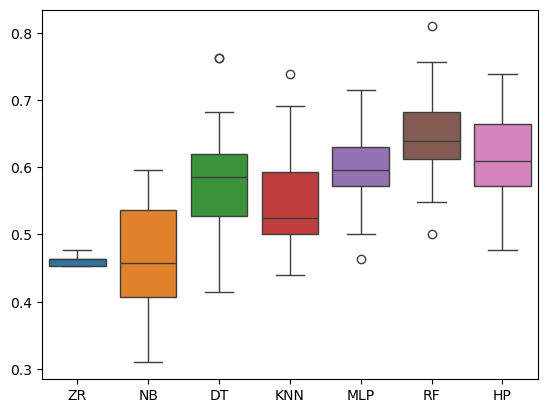

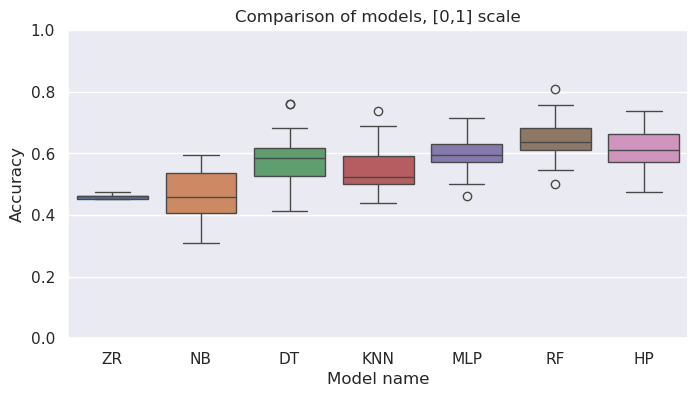

In [43]:
# Boxplot a comparison between all models
import matplotlib.pyplot as plt
import seaborn as sns

agg_data = {
    "ZR": zeroR_scores,
    "NB": naive_bayes_scores,
    "DT": decision_tree_scores,
    "KNN": knn_scores,
    "MLP": mlp_scores,
    "RF": rf_scores,
    "HP": hp_scores,
}

sns.boxplot(data={k: v["raw"] for k, v in agg_data.items()})
plt.show()

sns.set_theme(rc={"figure.figsize": (8, 4)})
fig, ax = plt.subplots()
ax.set(ylim=(0, 1))
ax.set_xlabel("Model name")
sns.boxplot(data={k: v["raw"] for k, v in agg_data.items()})
plt.ylabel("Accuracy")
plt.title("Comparison of models, [0,1] scale")
plt.show()

In [44]:
get_stat = lambda stat_name: [
    model_stats[stat_name] for model_name, model_stats in agg_data.items()
]

pd.set_option("display.float_format", "{:.2f}".format)
display(
    pd.DataFrame(
        {
            "Média": get_stat("mean"),
            "Desvio Padrão": get_stat("std"),
            "Limite Inferior": get_stat("inf"),
            "Limite Superior": get_stat("sup"),
        },
        index=pd.Index(agg_data.keys(), name="Método"),
    )
)

,Média,Desvio Padrão,Limite Inferior,Limite Superior
Método,,,,
ZR,0.46,0.01,0.46,0.47
NB,0.46,0.08,0.43,0.49
DT,0.58,0.08,0.55,0.61
KNN,0.55,0.07,0.53,0.58
MLP,0.60,0.06,0.57,0.62
RF,0.65,0.06,0.63,0.67
HP,0.62,0.07,0.59,0.64


Além das tabelas e dos gráficos bloxplot, será necessário apresentar também a tabela pareada dos resultados (p-values) dos testes de hipótese entre os pares de métodos. Na matriz triangular superior devem ser apresentados os resultados do **teste t pareado <u>corrigido</u>** (amostras dependentes) e na matriz triangular inferior devem ser apresentados os resultados do **teste não paramétrico de Wilcoxon**. Os valores da célula da tabela que rejeitarem a hipótese nula para um nível de significância de 95% devem ser escritos em negrito.

In [45]:
from scipy.stats import wilcoxon, t
from math import sqrt
from statistics import stdev

table_raw_stats = {key: value["raw"] for key, value in agg_data.items()}

model_pairs = {
    frozenset({model1, model2})
    for model1 in agg_data.keys()
    for model2 in agg_data.keys()
    if model1 != model2
}


def corrected_dependent_ttest(
    data1: Iterable, data2: Iterable, n_training_samples: int, n_test_samples: int
) -> dict[str, float]:
    n = len(data1)
    differences = [(data1[i] - data2[i]) for i in range(n)]
    sd = stdev(differences)
    divisor = 1 / n * sum(differences)
    test_training_ratio = n_test_samples / n_training_samples
    denominator = sqrt(1 / n + test_training_ratio) * sd
    t_stat = divisor / denominator
    # degrees of freedom
    df = n - 1
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return {"t_stat": t_stat, "pvalue": p}


def hipothesis_tests(
    pair: frozenset[str], n_training_samples, n_test_samples
) -> tuple[float, float]:
    model_name1, model_name2 = pair
    dataset1 = table_raw_stats[model_name1]
    dataset2 = table_raw_stats[model_name2]
    # print(f"{model_name1} vs {model_name2}")
    return (
        corrected_dependent_ttest(
            dataset1, dataset2, n_training_samples, n_test_samples
        ),
        wilcoxon(dataset1, dataset2),
    )


samples_per_fold = df.shape[0] / rkf.get_n_splits()

table_stats = {
    pair: hipothesis_tests(
        pair,
        df.shape[0] - samples_per_fold,
        samples_per_fold,
    )
    for pair in model_pairs
}

model_order = list(agg_data.keys())


def table_stat(model1_name: str, model2_name: str):
    keys = list(agg_data.keys())
    stats = table_stats[frozenset({model1_name, model2_name})]
    if keys.index(model1_name) < keys.index(model2_name):
        # lower triangle, wilcoxon
        pvalue = stats[1].pvalue
    else:
        # upper triangle, dependent t-test
        pvalue = stats[0]["pvalue"]
    mark = "**" if pvalue < 0.05 else ""
    # Manually setting the number of decimal places
    # and marking the p-value if it's significantly low
    return f"{mark}{pvalue:.3f}{mark}"


table = [
    (
        model_name1
        if model_name1 == model_name2  # diagonal
        else (
            "Not tested"
            if frozenset({model_name1, model_name2})
            not in table_stats  # not tested, all zeroes
            else f"{table_stat(model_name1, model_name2)}"
        )
    )
    for model_name1 in agg_data.keys()
    for model_name2 in agg_data.keys()
]


pd.set_option("display.float_format", "{:.3f}".format)
pd.DataFrame(
    np.array(table).reshape(len(agg_data), len(agg_data)), index=None, columns=None
)

,0,1,2,3,4,5,6
0,ZR,0.927,**0.000**,**0.000**,**0.000**,**0.000**,**0.000**
1,0.962,NB,**0.000**,**0.000**,**0.000**,**0.000**,**0.000**
2,**0.000**,**0.000**,DT,**0.046**,0.354,**0.000**,**0.003**
3,**0.000**,**0.000**,0.131,KNN,**0.000**,**0.000**,**0.000**
4,**0.000**,**0.000**,0.451,**0.007**,MLP,**0.000**,0.081
5,**0.000**,**0.000**,**0.002**,**0.000**,**0.002**,RF,**0.003**
6,**0.000**,**0.000**,**0.037**,**0.000**,0.243,**0.031**,HP
